In [32]:
import os
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.mcmc import NUTS, MCMC
from pyro.optim import Adam

# for CI testing
smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

%matplotlib inline

In [33]:
def model(x, data ):
    a_est = pyro.sample("a", Normal(loc=torch.zeros(1), scale=torch.ones(1)))
    b_est = pyro.sample('b' , Normal(loc=torch.zeros(1) , scale = torch.ones(1)))
    s2_est = pyro.sample("variance", Normal(loc=torch.zeros(1), scale=torch.ones(1)))
    curve = a_est * x + b_est * x**2
    y_hat = pyro.sample("yhat", Normal(loc= curve  , scale=s2_est), obs=data)
    return y_hat

In [34]:
X = torch.randn((10000,))
a = torch.tensor(5.)
b = torch.tensor(2.)

noise = torch.randn((10000,))

In [35]:
data = a*X + b*X**2 + noise

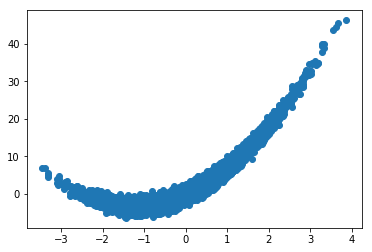

In [36]:
plt.scatter(X.numpy() , data.numpy())

In [37]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=500, warmup_steps=100).run(X, data)

/Users/Rhys/anaconda3/lib/python3.6/site-packages/pyro/poutine/trace_struct.py:17: UserWarning: Encountered NAN log_prob_sum at site 'yhat'
  warnings.warn("Encountered NAN log_prob_sum at site '{}'".format(name))


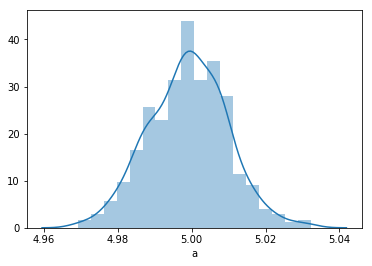

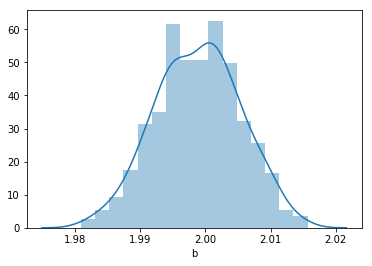

In [38]:
a_posterior = pyro.infer.EmpiricalMarginal(mcmc_run, "a")
b_posterior = pyro.infer.EmpiricalMarginal(mcmc_run, "b")
plt.figure()
figa = sns.distplot(a_posterior.get_samples_and_weights()[0])
figa.set(xlabel = 'a')
plt.figure()
figb = sns.distplot(b_posterior.get_samples_and_weights()[0])
figb.set(xlabel = 'b')
plt.show()